# STACOM 2018 Training

Copyright (c) 2018 Eric Kerfoot, see LICENSE file

This notebook is for training the neural network for implementing our entry into the LVQuant challenge. This will read data from `cardiac-dig_cloned_20.npz` so this must be generated beforehand by running `deformclone.py` first on the original `cardiac-dig.mat` file provided through the challenge website. 

### First step is to import our libraries and set some useful values:

In [1]:
%matplotlib inline
from __future__ import print_function,division
import os, glob
from collections import OrderedDict
from functools import partial
import numpy as np
import scipy.io

import matplotlib.pyplot as plt

try:
    from importlib import reload # Python 3
except ImportError:
    pass

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

import net, trainimagesource, trainutils, pytorchutils

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

0.4.0


### Load the data from the pre-generated file:

In [2]:
numImagesPerSub=20
validSize=numImagesPerSub*15

# images and masks are in height/width/batch/clone order
#HWBD, HWBD, 1B
images_LV,masks,phase,numClones=net.loadDataCloned('./cardiac-dig_cloned_20.npz')
        
images_LV=images_LV.transpose([3,2,0,1])[...,np.newaxis] # change to DBHWC
masks=masks.transpose([3,2,0,1]) # change to DBHW

itrain=np.concatenate(images_LV) 
mtrain=np.concatenate(masks) 

### Setup the image source object which generated augmented batches of image:

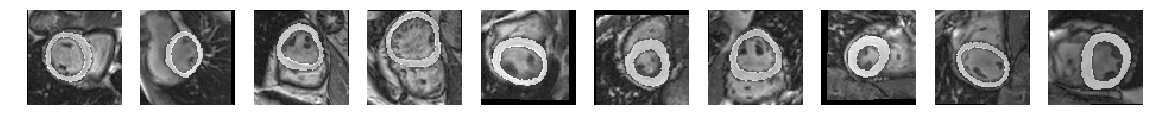

In [3]:
augs=[trainimagesource.rot90BothAugment, trainimagesource.transposeBothAugment,trainimagesource.flipBothAugment,
      partial(trainimagesource.shiftMaskAugment,dimfract=15,order=0),
      pytorchutils.convertAug
]

src=trainimagesource.TrainImageSource(itrain,mtrain,augs)

testSize=10
timgs,tmasks=src.getBatch(testSize)
fig = plt.figure(figsize = (20,30))

for i in range(testSize):
    plt.subplot(1,testSize,i+1)
    plt.axis('off')
    plt.imshow(timgs[i,0]+tmasks[i,0]*0.5)

### Train network to segment images:

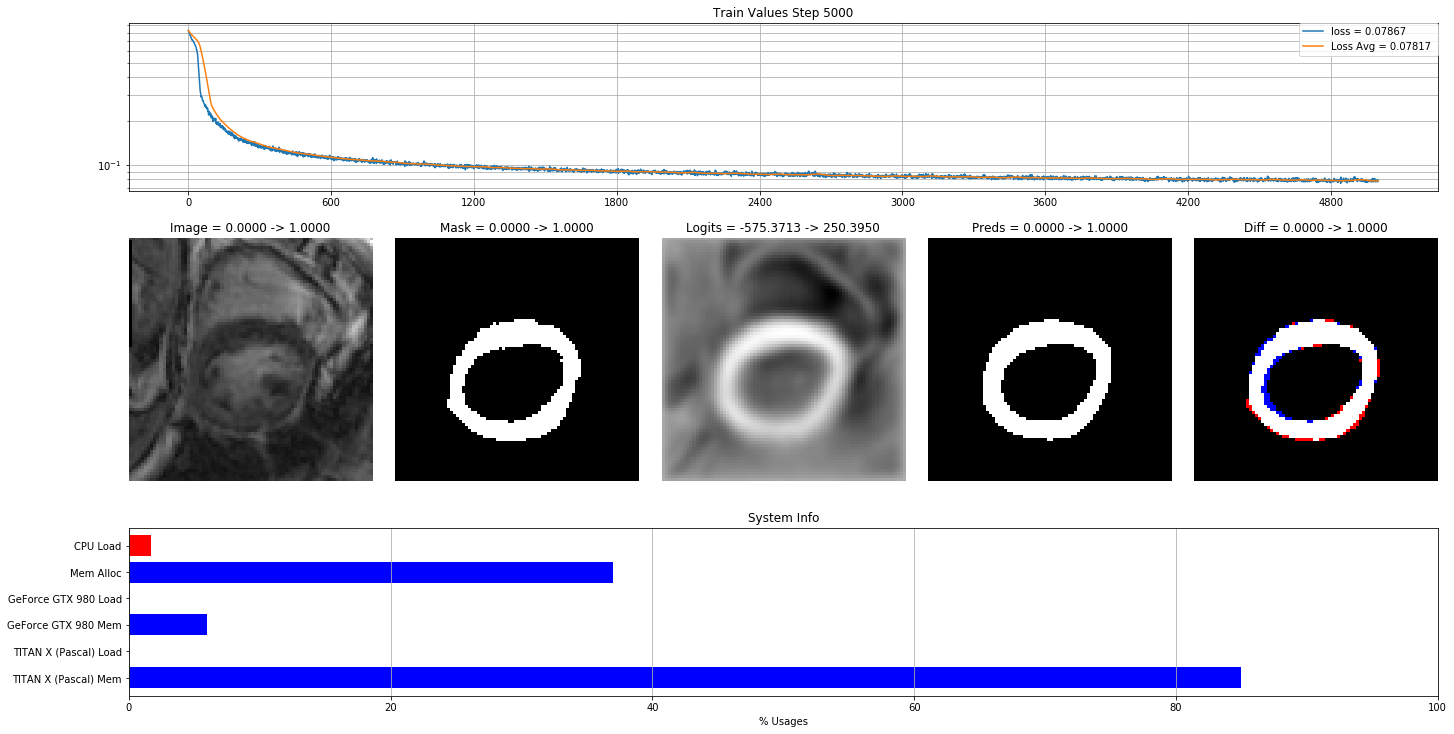

In [7]:
class UnetMgrNB(net.UnetMgr):
    '''Manager class used to integrate UnetMgr with Jupyter notebook visualization.'''
    fig=None
    
    def saveStep(self,step,steploss): # disable validation for final training
        pass
    
    def updateStep(self,step,steploss):
        super(UnetMgrNB,self).updateStep(step,steploss)
        if step<10 or step%20==0:
            images,masks=self.traininputs
            logits,preds=self.netoutputs

            mask=masks[0,0].cpu().data.numpy()
            preds=preds[0].cpu().data.numpy()

            imgmap=OrderedDict([
                ('Image',images[0,0].cpu().data.numpy()),
                ('Mask',mask),
                ('Logits',logits[0,0].cpu().data.numpy()),
                ('Preds',preds),
                ('Diff',np.stack([mask,mask*preds,preds],axis=2).astype(np.float32)),
            ])

            graphs={'loss':self.steplosses,'Loss Avg':self.lossavgs}
        
            self.fig,ax=trainutils.plotGraphImages('Train Values Step %i'%(step,),graphs,imgmap,fig=self.fig)
            clear_output(wait=True)
            display(plt.gcf())
    

params={
    'learningRate':1e-4,
    'trainSteps':5000,
    'batchSize':600,
    'filters':(16, 32, 64, 128, 256), # good baseline result
    'strides':( 1,  2,  2,   2,   2),
    'resunits':2,
    'kernelsize':3,
    'datashape':(itrain.shape,mtrain.shape),
    'isCuda':True,
}
        
savedirprefix=os.path.join(os.getcwd(),'SegAll')

mgr=UnetMgrNB(params,(itrain,mtrain),(),augs,savedirprefix)
mgr.train()
clear_output(wait=True)

### Inspect output, looking at IoU metric for inferred segmentations:

IOU mean: 0.10759281613395566
0 Image #: 1210 IoU: 0.71924
1 Image #:  365 IoU: 0.36515
2 Image #:  372 IoU: 0.31066
3 Image #:  373 IoU: 0.29709
4 Image #:  620 IoU: 0.28212
5 Image #:  374 IoU: 0.27466
6 Image #: 1704 IoU: 0.27423
7 Image #: 1702 IoU: 0.25221
8 Image #:  868 IoU: 0.24780
9 Image #:  371 IoU: 0.24458


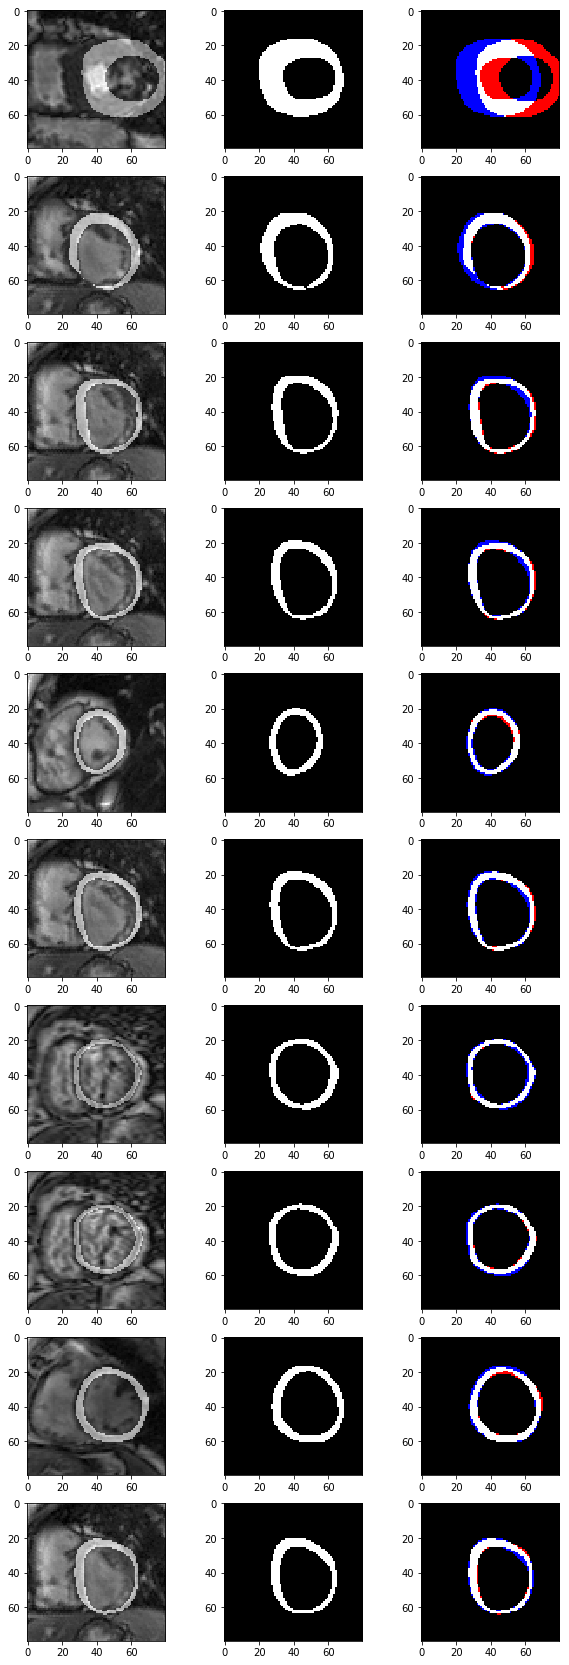

In [10]:
inputs=images_LV[0,:,np.newaxis,:,:,0],masks[0,:]

testparams=dict(params)
testparams['isTraining']=False
testmgr=mgr

results=testmgr.infer(inputs,params['batchSize'])

allpreds=np.vstack([r[1] for r in results])
iou=np.asarray([trainutils.iouMetric(m,p) for m,p in zip(inputs[1],allpreds)])

print('IOU mean:',iou.mean())

sorts=np.argsort(iou)
numchecks=10

plt.figure(figsize=(10,30))
for i in range(numchecks): # 10 worst segmentations
    index=sorts[-i-1]
    im=inputs[0][index]
    m=inputs[1][index]
    p=allpreds[index]
    
    print(i,'Image #:','%4i'%index,'IoU:','%1.5f'%iou[index])
    
    plt.subplot(numchecks,3,i*3+1)
    plt.imshow(im[0,]+m*0.5)
    plt.subplot(numchecks,3,i*3+2)
    plt.imshow(p)
    plt.subplot(numchecks,3,i*3+3)
    plt.imshow(np.stack([m,m*p,p],axis=2).astype(np.float32))

### Run model inference on the test dataset and save the results:

In [7]:
def infer(savedir,batchSize):
    '''Load a model from `savedir', generate segmentations, and save `testresults.npz' back to `savedir'.'''
    dat=scipy.io.loadmat('lvquan_test_images_30sub.mat')
    images=dat['images_LV_30'].transpose([2,0,1]).astype(np.float32)
    
    if savedir is None:
        allpreds=dat['results']
    else:    
        params={
            'learningRate':1e-4,
            'batchSize':batchSize,
            'filters':(16, 32, 64, 128, 256),
            'strides':( 1,  2,  2,   2,   2),
            'resunits':2,
            'kernelsize':3,
            'isCuda':True
        }
        
        assert os.path.isdir(savedir), '%r not a directory'%savedir
        
        print('Inferring in',savedir)
        mgr=net.UnetMgr(params,(),(),[],savedir)
        results=mgr.infer((images[:,np.newaxis],),params['batchSize'])
        allpreds=np.vstack([r[1] for r in results])
        
        np.savez_compressed(os.path.join(savedir,'testresults'),results=allpreds)
        
        
infer(glob.glob('./SegAll-*')[-1],600) # run inference on the last directory, which will be the most recent one generated

Inferring in ./SegAll-20181018160428
